In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

In [2]:
cols = ["area", "per", "circ", "class"]
df = pd.read_csv("cell_features.csv", names=cols)
df = df.iloc[1:].reset_index(drop=True)
df.head()

,area,per,circ,class
0,1.3673266821319388,1.1692307692307693,0.6176734647016626,0
1,0.8456346527970778,0.9194405594405595,0.6177639802378739,0
2,0.9719356357304505,1.0177622377622377,0.5794713470551918,0
3,0.9884955768943541,1.0018181818181817,0.6082526904536296,0
4,1.063428412616486,1.0310489510489511,0.6177842286432687,0


In [3]:
df["class"] = (df['class'] == '1').astype(int)

#Train, Validation, Test Datasets

In [4]:
print(df)

                    area                 per                circ  class
0     1.3673266821319388  1.1692307692307693  0.6176734647016626      0
1     0.8456346527970778  0.9194405594405595  0.6177639802378739      0
2     0.9719356357304505  1.0177622377622377  0.5794713470551918      0
3     0.9884955768943541  1.0018181818181817  0.6082526904536296      0
4      1.063428412616486  1.0310489510489511  0.6177842286432687      0
...                  ...                 ...                 ...    ...
3067  1.2242945958871354  1.1028632025450689  0.5948577805613809      0
3068  0.9044476327116212  0.9840933191940615  0.5519266522804898      0
3069  0.9534194165471066  1.0010604453870626   0.562255737772606      0
3070  1.2732663797226207  1.2216330858960764  0.5042062283539175      0
3071                 1.0                 1.0  0.3726277953007894      1

[3072 rows x 4 columns]


In [5]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [6]:
def scale_dataset(dataframe, oversample=False):
  X = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

In [7]:
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [8]:
print(len(train[train[:, -1]==0]))
print(len(train[train[:, -1]==1]))

1390
1390


#Neural Network

In [9]:
  def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentropy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.show()

In [10]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
                                                                        tf.keras.metrics.Precision(),
                                                                        tf.keras.metrics.Recall(),
                                                                        tf.keras.metrics.AUC(name='AUC')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - AUC: 0.8506 - accuracy: 0.7853 - loss: 0.4928 - precision: 0.7639 - recall: 0.8194 - val_AUC: 0.9280 - val_accuracy: 0.6645 - val_loss: 0.6495 - val_precision: 0.4059 - val_recall: 0.9718
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9450 - accuracy: 0.8889 - loss: 0.2948 - precision: 0.8785 - recall: 0.9066 - val_AUC: 0.9506 - val_accuracy: 0.8779 - val_loss: 0.3947 - val_precision: 0.6683 - val_recall: 0.9366
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9548 - accuracy: 0.9013 - loss: 0.2645 - precision: 0.8897 - recall: 0.9166 - val_AUC: 0.9587 - val_accuracy: 0.8941 - val_loss: 0.3028 - val_precision: 0.7016 - val_recall: 0.9437
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9589 - accuracy: 0.9109 - loss: 0.2454 - precision: 0.9028 - recall: 0.9263 - val_AUC: 0.9682 - val_accuracy: 0.9104 - val_loss: 0.2609 - val_precision: 0.7430 - val_recall: 0.9366
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━

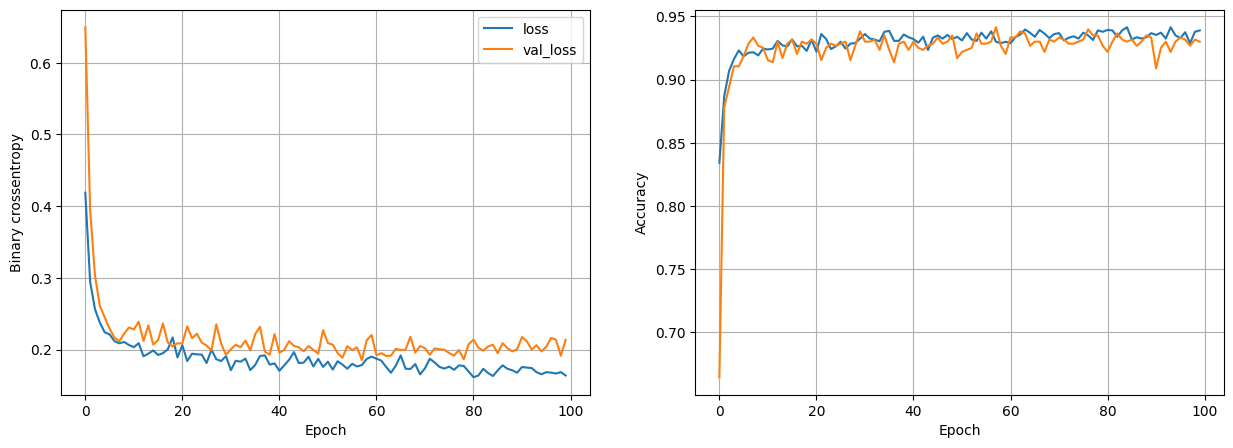

In [12]:
plot_history(history)

In [13]:
nn_model.evaluate(X_test, y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9755 - accuracy: 0.9127 - loss: 0.1891 - precision: 0.7982 - recall: 0.8776 


[0.20992423593997955,
 0.9154471755027771,
 0.7692307829856873,
 0.9090909361839294,
 0.9718723893165588]

In [14]:
y_pred = (nn_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       472
           1       0.77      0.91      0.83       143

    accuracy                           0.92       615
   macro avg       0.87      0.91      0.89       615
weighted avg       0.92      0.92      0.92       615



In [15]:
nn_model.save('sickle_cell_model.keras')

# Testing

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


KNN model saved to knn_model.pkl
KNN Model Evaluation:
Accuracy: 0.865040650406504
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       480
           1       0.63      0.91      0.75       135

    accuracy                           0.87       615
   macro avg       0.80      0.88      0.83       615
weighted avg       0.90      0.87      0.87       615

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Ensemble Model Evaluation:
Accuracy: 0.8682926829268293
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       480
           1       0.63      0.96      0.76       135

    accuracy                           0.87       615
   macro avg       0.81      0.90      0.84       615
weighted avg       0.91      0.87      0.88       615


Running ensemble prediction on rbc.jpeg
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


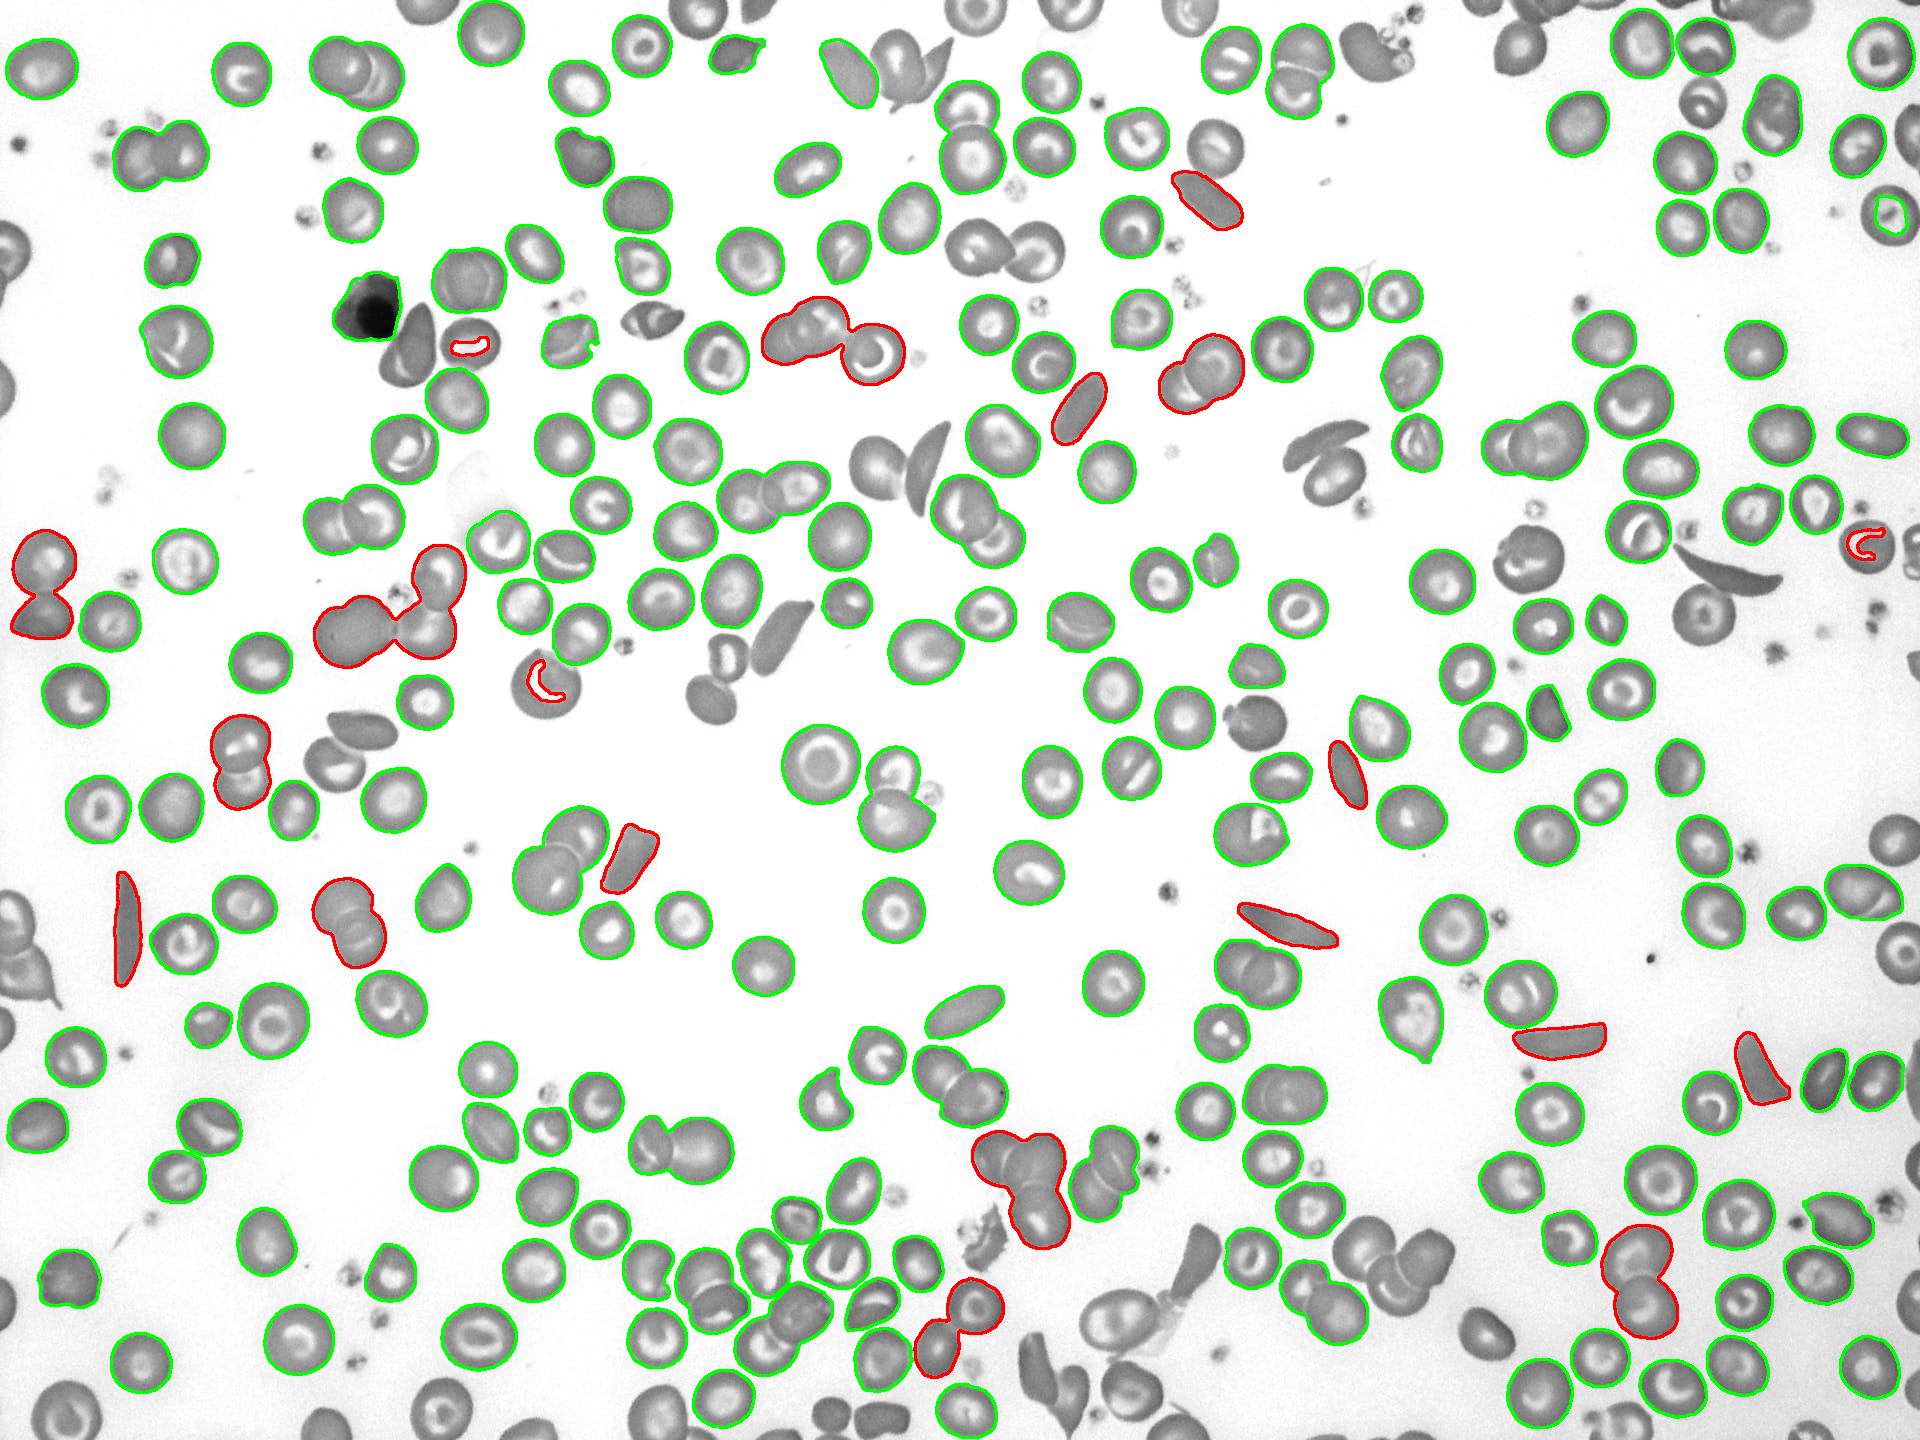

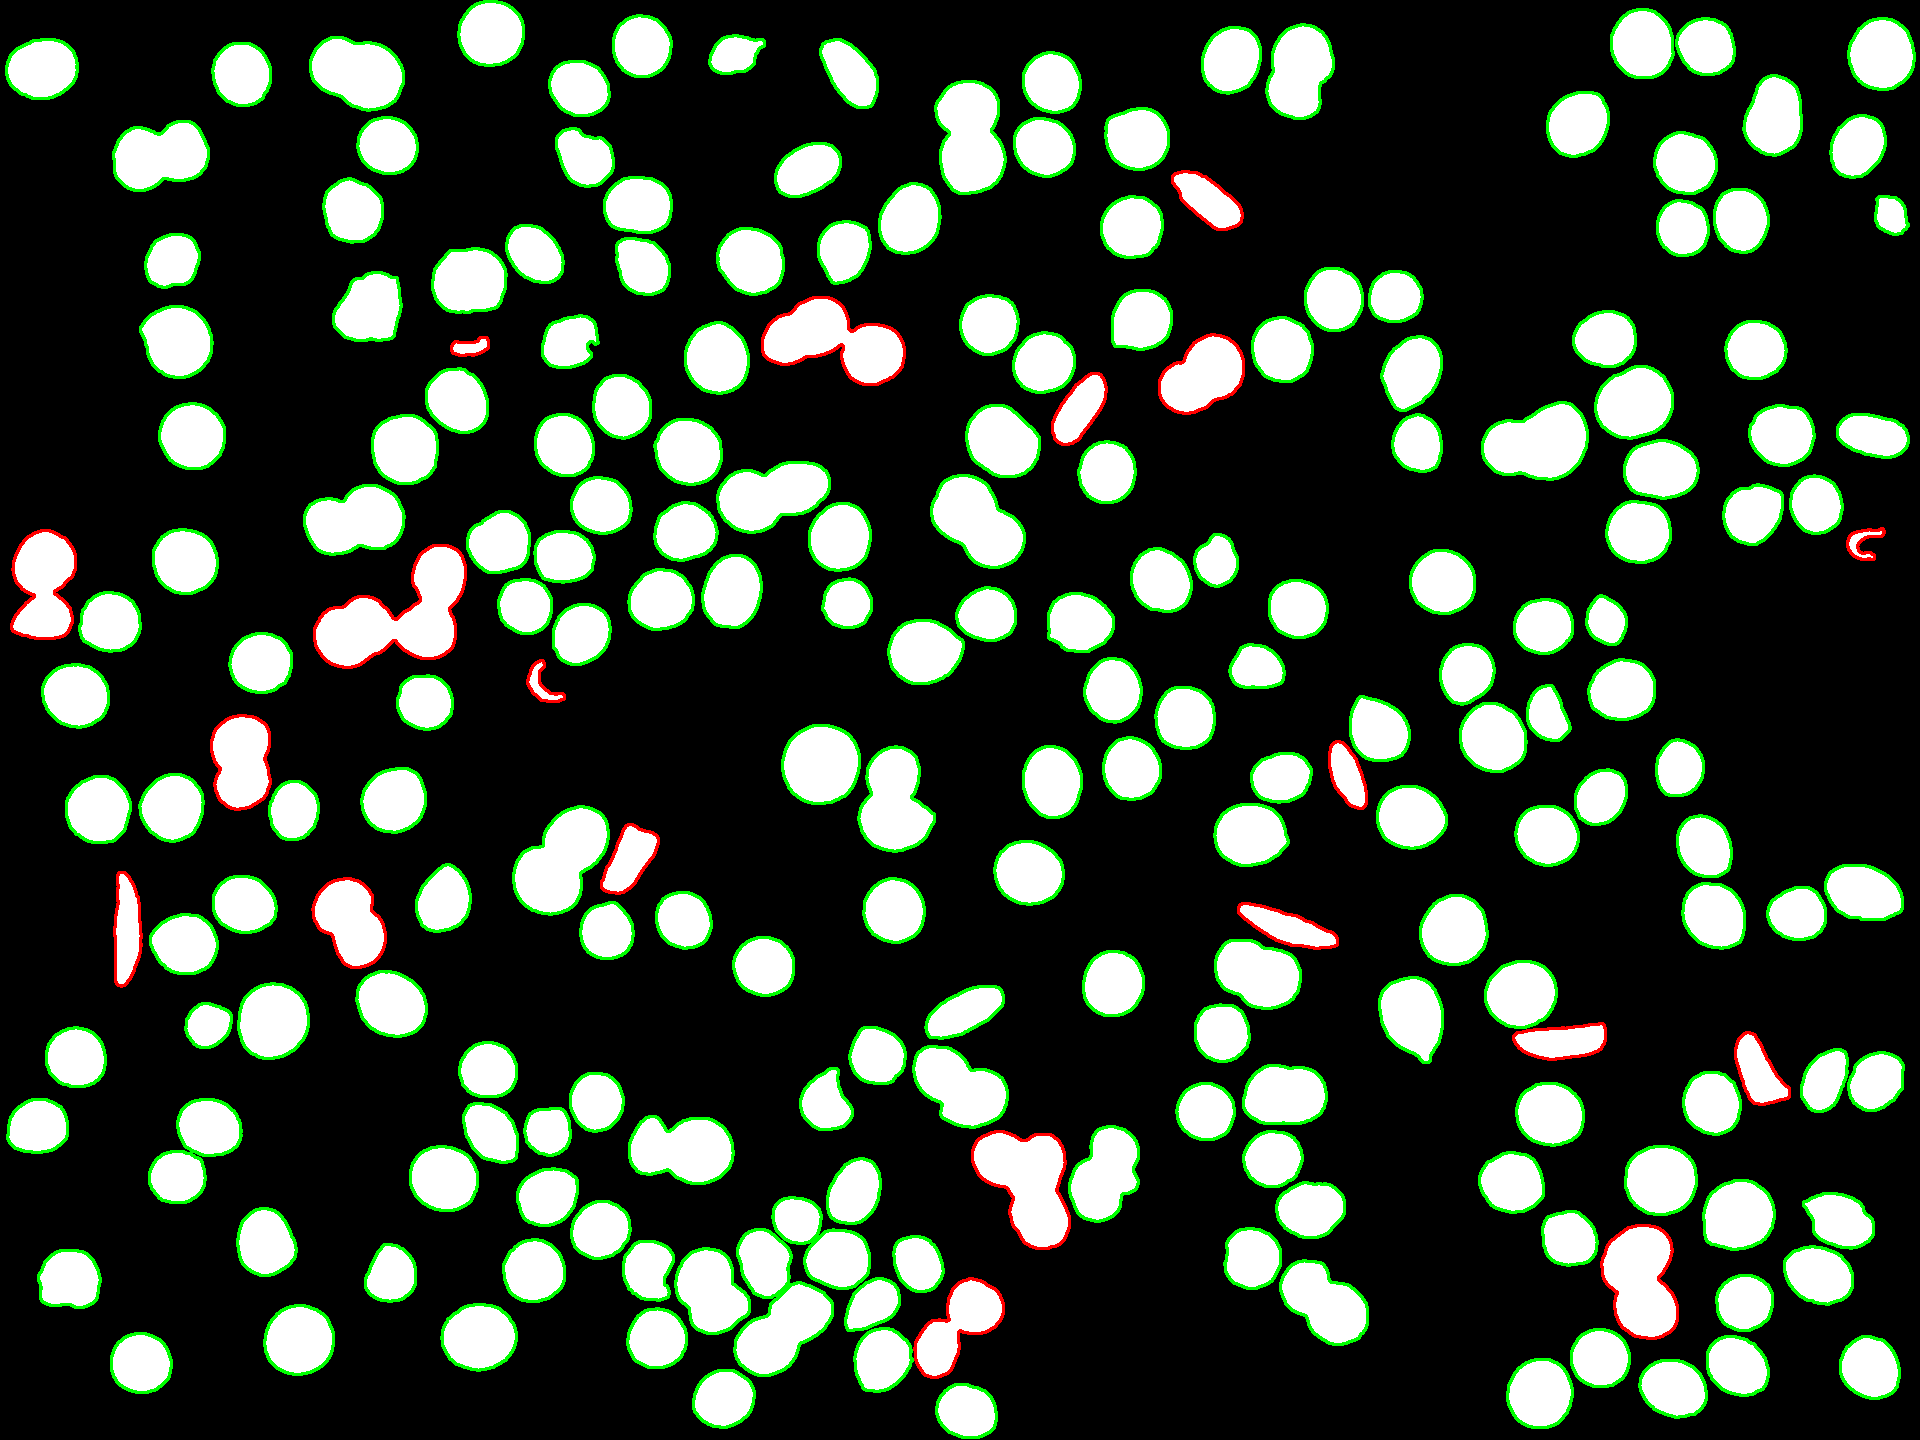

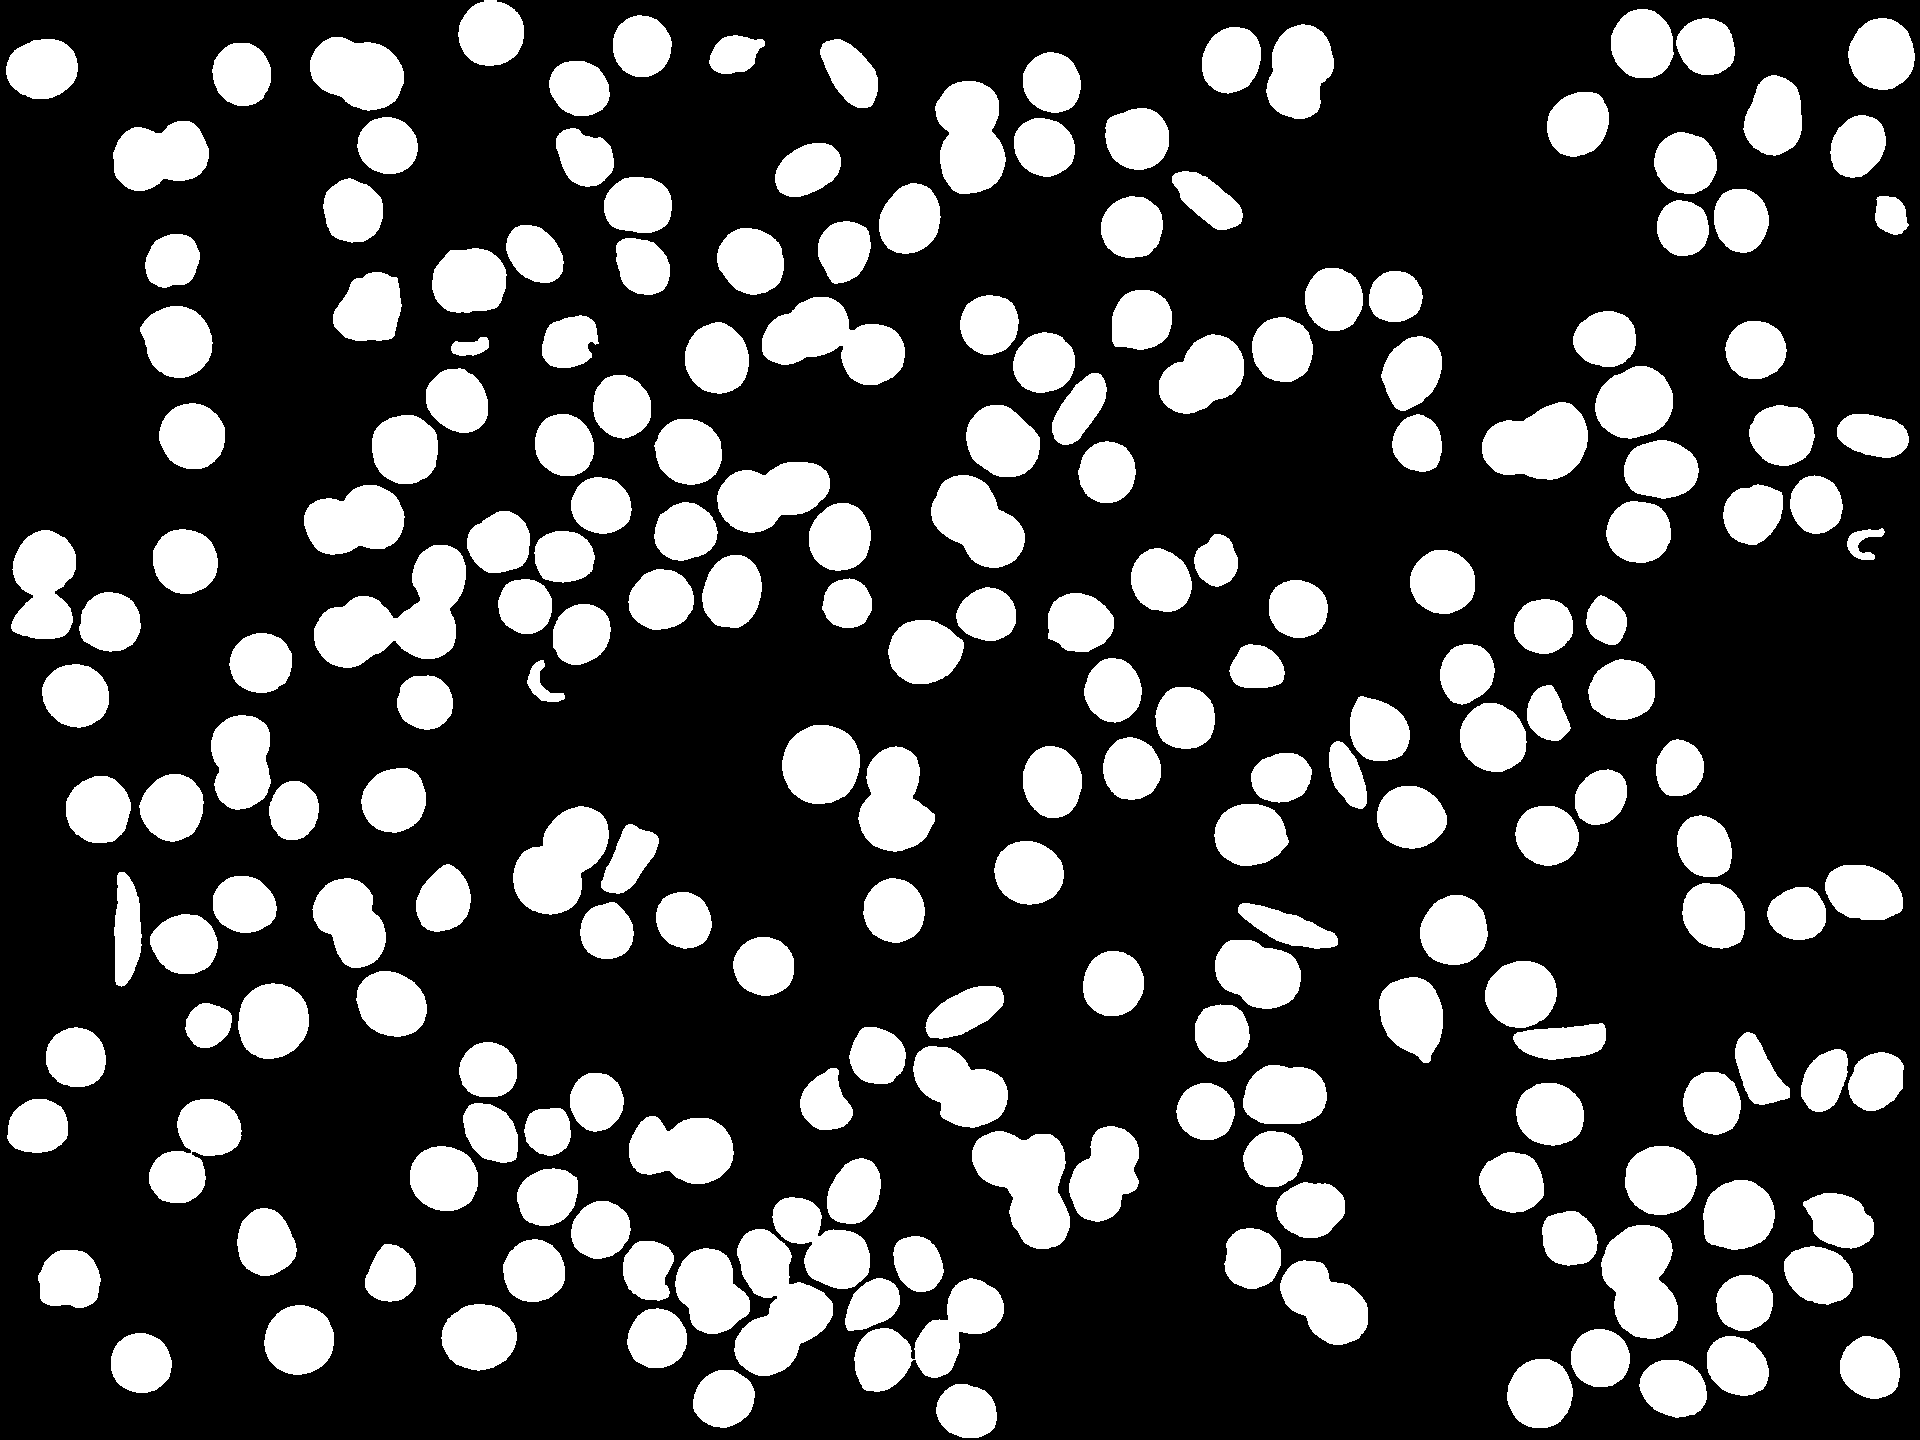

Sickle cell detection and image marking complete. Images saved and displayed.


In [32]:
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
from skimage.feature import canny
from scipy import ndimage as ndi
import math
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from google.colab.patches import cv2_imshow

def image_prep(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Error: Unable to read image at {path}")

    edges = canny(img / 255.0)
    fill_img = ndi.binary_fill_holes(edges)
    label_objects, nb_labels = ndi.label(fill_img)

    mask_size = 400
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > mask_size
    mask_sizes[0] = 0
    img_cleaned = mask_sizes[label_objects]

    labeled_img, num_features = ndi.label(img_cleaned)
    binary_mask = (labeled_img > 0).astype(np.uint8) * 255

    kernel = np.ones((3, 3), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return labeled_img, num_features, img, binary_mask

def numofneighbour(mat, i, j, searchValue):
    count = 0
    if i > 0 and mat[i - 1][j] == searchValue:
        count += 1
    if j > 0 and mat[i][j - 1] == searchValue:
        count += 1
    if i < len(mat) - 1 and mat[i + 1][j] == searchValue:
        count += 1
    if j < len(mat[i]) - 1 and mat[i][j + 1] == searchValue:
        count += 1
    return count

def findperimeter(mat, num_features):
    perimeter = [0] * (num_features + 1)
    for i in range(len(mat)):
        for j in range(len(mat[i])):
            if mat[i][j] != 0:
                perimeter[mat[i][j]] += (4 - numofneighbour(mat, i, j, mat[i][j]))
    return perimeter

def extract_area_perim(img, num_features):
    area = [0] * (num_features + 1)
    for i in range(len(img)):
        for j in range(len(img[i])):
            value = img[i][j]
            if value != 0:
                area[value] += 1
    return area, findperimeter(img, num_features)

def extract_circularity(area, perimeter):
    return [
        (4 * math.pi * area[i]) / (math.pow(perimeter[i], 2)) if perimeter[i] != 0 else 0
        for i in range(len(area))
    ]

def convert_to_relative(cellAreas, cellPerims):
    avg_area = np.mean(cellAreas) if cellAreas else 1
    avg_perim = np.mean(cellPerims) if cellPerims else 1
    return [area / avg_area for area in cellAreas], [perim / avg_perim for perim in cellPerims]

def removeOutliers(area, perim, img):
    if not area:
        return [], [], img
    mean = np.mean(area)
    std = np.std(area)
    new_area, new_perim = [], []
    new_img = img.copy()

    for i in range(len(area)):
        if area[i] <= mean + 3.5 * std:
            new_area.append(area[i])
            new_perim.append(perim[i])
        else:
            new_img[new_img == i + 1] = 0

    if not new_area and area:
        max_index = np.argmax(area)
        new_area.append(area[max_index])
        new_perim.append(perim[max_index])

    return new_area, new_perim, new_img

def train_knn_model(X_train, y_train, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    return knn

def save_knn_model(knn_model, model_path='knn_model.pkl'):
    joblib.dump(knn_model, model_path)
    print(f"KNN model saved to {model_path}")

def load_knn_model(model_path='knn_model.pkl'):
    return joblib.load(model_path)

def ensemble_predict(nn_model, knn_model, features_scaled):
    if features_scaled.size == 0:
        return np.array([])

    nn_predictions = nn_model.predict(features_scaled)
    nn_labels = (nn_predictions > 0.5).astype(int).flatten()

    knn_predictions = knn_model.predict(features_scaled)

    ensemble_predictions = []
    for nn_pred, knn_pred in zip(nn_labels, knn_predictions):
        ensemble_predictions.append(int(nn_pred + knn_pred >= 1))

    return np.array(ensemble_predictions)

def predict_sickle_cells(image_path, nn_model_path='sickle_cell_model.keras',
                        knn_model_path='knn_model.pkl', scaler_path='scaler.pkl'):

    nn_model = tf.keras.models.load_model(nn_model_path)
    knn_model = load_knn_model(knn_model_path)

    scaler = joblib.load(scaler_path) if os.path.exists(scaler_path) else None

    labeled_img, num_features, original_img_gray, binary_mask = image_prep(image_path)
    cv2.imwrite('binary_mask.jpg', binary_mask)

    areaArray, perimArray = extract_area_perim(labeled_img, num_features)
    areaArray, perimArray = areaArray[1:], perimArray[1:] if len(areaArray) > 1 else ([], [])

    circularityArray = extract_circularity(areaArray, perimArray)
    relativeAreaArray, relativePerimArray = convert_to_relative(areaArray, perimArray)
    _, _, img_no_outliers = removeOutliers(relativeAreaArray, relativePerimArray, labeled_img.copy())

    contours = []
    for i in range(1, num_features + 1):
        mask = np.uint8(labeled_img == i)
        cell_contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours.append(cell_contours)

    features_for_prediction = np.array([
        [relativeAreaArray[i], relativePerimArray[i], circularityArray[i]]
        for i in range(len(relativeAreaArray))
    ])

    if features_for_prediction.size:
        features_scaled = scaler.transform(features_for_prediction) if scaler else features_for_prediction
        predicted_labels = ensemble_predict(nn_model, knn_model, features_scaled)
    else:
        predicted_labels = []

    original_img_color = cv2.cvtColor(original_img_gray, cv2.COLOR_GRAY2BGR)
    marked_image = original_img_color.copy()
    mask_colored = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)

    for i, cell_contours in enumerate(contours[:len(predicted_labels)]):
        color = (0, 0, 255) if predicted_labels[i] == 1 else (0, 255, 0)
        cv2.drawContours(marked_image, cell_contours, -1, color, 2)
        cv2.drawContours(mask_colored, cell_contours, -1, color, 2)

    cv2.imwrite('sickle_cells_marked.jpg', marked_image)
    cv2.imwrite('sickle_cells_mask_marked.jpg', mask_colored)

    return marked_image, mask_colored, binary_mask

def main():
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from imblearn.over_sampling import RandomOverSampler

    cols = ["area", "per", "circ", "class"]
    df = pd.read_csv("cell_features.csv", names=cols)
    df = df.iloc[1:].reset_index(drop=True)
    df["class"] = (df['class'] == '1').astype(int)

    train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

    def scale_dataset(dataframe, oversample=False):
        X = dataframe[dataframe.columns[:-1]].values
        y = dataframe[dataframe.columns[-1]].values

        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        if oversample:
            ros = RandomOverSampler()
            X, y = ros.fit_resample(X, y)

        if dataframe is train:
            joblib.dump(scaler, 'scaler.pkl')

        data = np.hstack((X, np.reshape(y, (-1, 1))))
        return data, X, y

    train, X_train, y_train = scale_dataset(train, oversample=True)
    valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
    test, X_test, y_test = scale_dataset(test, oversample=False)

    knn_model = train_knn_model(X_train, y_train)
    save_knn_model(knn_model)

    from sklearn.metrics import accuracy_score, classification_report
    y_pred = knn_model.predict(X_test)
    print("KNN Model Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

    nn_model = tf.keras.models.load_model('sickle_cell_model.keras')

    ensemble_preds = ensemble_predict(nn_model, knn_model, X_test)
    print("\nEnsemble Model Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, ensemble_preds)}")
    print(classification_report(y_test, ensemble_preds))

    input_image_path = 'rbc.jpeg'
    print(f"\nRunning ensemble prediction on {input_image_path}")
    marked_image, mask_colored, binary_mask = predict_sickle_cells(input_image_path)
    cv2_imshow(marked_image)
    cv2_imshow(mask_colored)
    cv2_imshow(binary_mask)
    print("Sickle cell detection and image marking complete. Images saved and displayed.")

if __name__ == '__main__':
    main()